In [131]:
import numpy as np
import matplotlib.pyplot as plt



### Parse and sort into training and testing data set
Structure:
I datasett-arrayet er hver rad ett enkelt sample. Første kolonne betegner klassetilhørlighet, og de andre kolonnene betegner egenskapsverdiene til sampelet:
$$
\begin{bmatrix}
\theta_1 & {x}_{1,1} & {x}_{1,2} & {x}_{1,3} & {x}_{1,4}\\
\theta_2 & {x}_{2,1} & {x}_{2,2} & {x}_{2,3} & {x}_{2,4}\\
. & . & . & . & . \\
. & . & . & . & . \\
\theta_n & {x}_{n,1} & {x}_{n,2} & {x}_{n,3} & {x}_{n,4}\\
\end{bmatrix}	
$$
hvor $\theta_k \in \left\{ \omega_1, \omega_2 \right\}$ er klassetilhørigheten til sampelet $\vec{x}_k$, med komponenter $x_{k,i},\quad i = 1, \dots, d$

Datasett 1: 5 kolonner (4 egenskaper), 300 rader (300 sampler)

Datasett 2: 4 kolonner (3 egenskaper), 300 rader (300 sampler)

Datasett 3: 4 kolonner (3 egenskaper), 400 rader (400 sampler)

## Plott egenskap 1 for alle objekter av klasse 1 og klasse 2
Vi kan se at distribusjonen ligner på en normalfordeling. Den samme egenskapen ser ut til å ha forskjellig forventningsverdi $\mu$, og muligens forskjellig varians $\sigma$

[[ 1.        -6.245578   1.748423  -0.2890453]
 [ 1.        -1.933312  -5.752458   3.645188 ]
 [ 1.        -0.8100212  5.603209   2.219433 ]
 ...
 [ 2.         0.4347897 -1.68088    0.7552309]
 [ 2.        -1.136312   0.3776155  0.3852432]
 [ 2.        -0.8073784  1.365056   2.730112 ]]


/var/folders/27/hdf_pgmj42s7jmq2c5bj7_fw0000gn/T/ipykernel_28921/3853347023.py:30: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(class_1_feature_1, class_1_feature_2, marker='x', edgecolors='b')


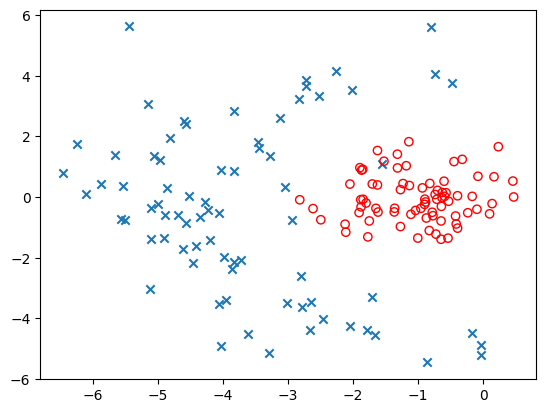

In [132]:
class DataSet():
    def __init__(self, path):
        self.path = path
        data = np.loadtxt(path)
        data_training = []
        data_testing = []
        n_samples = data.shape[0]
        i = 0

        while i < n_samples-1:
            data_training.append(data[i])
            data_testing.append(data[i+1])
            i += 2

        self.training = np.array(data_training)
        self.testing = np.array(data_testing)
        
path = 'data/ds-2.txt'
print(np.loadtxt(path))
data = DataSet(path)
first_feature = 1
second_feature = 2
class_1_dataset = data.training[data.training[:,0] == 1]
class_2_dataset = data.training[data.training[:,0] == 2]
class_1_feature_1 = class_1_dataset[:,first_feature]
class_2_feature_1 = class_2_dataset[:,first_feature]
class_1_feature_2 = class_1_dataset[:,second_feature]
class_2_feature_2 = class_2_dataset[:,second_feature]

plt.scatter(class_1_feature_1, class_1_feature_2, marker='x', edgecolors='b')
plt.scatter(class_2_feature_1, class_2_feature_2, facecolors='none', edgecolors='r')

# Minimum Feilrate Klassifikator
Her settes opp funksjoner for å beregne størrelsene som er nødvendig for å sette opp diskriminantfunksjonen som skal brukes for å bestemme klassene i nye sampler.

Til slutt kombineres disse i en "pipeline" som tar inn et gitt datasett, trener opp klassifikatoren og bruker den på test-settet.

In [133]:
def get_a_priori_probability(dataset, class_number):
    num_samples = dataset.shape[0]
    class_samples = dataset[dataset[:, 0] == class_number]
    class_sample_count = class_samples.shape[0]
    return class_sample_count/num_samples

def get_sample_mean(dataset, class_number):
    class_samples = dataset[dataset[:,0] == class_number] # extract data only for the given class
    class_samples = class_samples[:, 1:] # remove the first column (the assigned class)
    mu = np.mean(class_samples, axis = 0) # get the mean of the samples
    return mu

def get_sample_variance(dataset, class_number, mu):
    class_samples = dataset[dataset[:, 0] == class_number, 1:]
    mean_centered_samples = class_samples - mu
    n_samples = class_samples.shape[0]
    variance = np.dot(mean_centered_samples.T, mean_centered_samples) / n_samples
    return variance

def get_W_matrix(sigma):
    return -(1/2)*np.linalg.inv(sigma)

def get_w_vector(sigma, mu):
    return np.linalg.inv(sigma)@mu

def get_w0(sigma, mu, P_class):
    return -(1/2)*mu.T@np.linalg.inv(sigma)@mu - (1/2)*np.log(np.linalg.det(sigma)) + np.log(P_class)

def g_i(sample, W_i, w_i, w_i_0):
    return sample.T@W_i@sample + w_i.T@sample + w_i_0

def discriminant_function(sample, W_1, W_2, w_1, w_2, w_1_0, w_2_0):
    sample = sample[1:] # ignore class column
    g_1 = g_i(sample, W_1, w_1, w_1_0)
    g_2 = g_i(sample, W_2, w_2, w_2_0)
    return g_1-g_2

def minimum_error_pipeline(training_set, testing_set):
    P_class_1 = get_a_priori_probability(training_set, 1)
    P_class_2 = get_a_priori_probability(training_set, 2)
    mu_1 = get_sample_mean(training_set, 1)
    mu_2 = get_sample_mean(training_set, 2)
    sigma_1 = get_sample_variance(training_set, 1, mu_1)
    sigma_2 = get_sample_variance(training_set, 2, mu_2)

    W_1 = get_W_matrix(sigma_1)
    W_2 = get_W_matrix(sigma_2)
    w_1 = get_w_vector(sigma_1, mu_1)
    w_2 = get_w_vector(sigma_2, mu_2)
    w_1_0 = get_w0(sigma_1, mu_1, P_class_1)
    w_2_0 = get_w0(sigma_2, mu_2, P_class_2)
    n_correct = 0
    n_incorrect = 0
    for sample in testing_set:
        true_class = sample[0]
        score = discriminant_function(sample, W_1, W_2, w_1, w_2, w_1_0, w_2_0)
        if score > 0:
            assigned_class = 1
        else:
            assigned_class = 2
        if (true_class == assigned_class):
            n_correct += 1
        else:
            n_incorrect += 1
    return n_correct/(n_correct+n_incorrect)
    

## Minste kvadraters

In [134]:
def lq_discriminant(sample, a):
    x = sample[1:]
    y = np.insert(x, 0, 1)
    return a.T@y

def lq_pipeline(training_set, testing_set):
    Y = np.copy(training_set)
    Y[:,0] = 1 
    b = training_set[:, 0]
    b = np.where(b == 2, -1, 1)
    a = np.linalg.inv(Y.T@Y)@Y.T@b

    n_correct = 0
    n_incorrect = 0
    for sample in testing_set:
        true_class = sample[0]
        result = lq_discriminant(sample, a)
        if result >= 0:
            assigned_class = 1
        else:
            assigned_class = 2
        if assigned_class == true_class:
            n_correct += 1
        else:
            n_incorrect += 1

    return n_correct/(n_correct+n_incorrect)

# Nærmeste nabo klassifikator

In [135]:
def nnr_pipeline(training_set, testing_set):
    n_correct = n_incorrect = 0

    for point in testing_set:
        x = point[1:]
        true_class = point[0]
        min_dist = np.inf
        for point_i in training_set:
            x_i = point_i[1:]
            class_i = point_i[0]
            dist_i = np.linalg.norm(x-x_i)
            if dist_i < min_dist:
                min_dist = dist_i
                assigned_class = class_i
        if assigned_class == true_class:
            n_correct += 1
        else:
            n_incorrect += 1

    return n_correct/(n_correct+n_incorrect)

Powerset function to get all possible feature combinations:

In [136]:
from itertools import chain, combinations

def powerset(array):
    array = list(array)
    power_set = chain.from_iterable(combinations(array, r) for r in range(1, len(array) + 1))
    return [list(x) for x in power_set]

# Bestemme beste kombinasjon av egenskaper

In [137]:
data_1 = DataSet('data/ds-1.txt')
data_2 = DataSet('data/ds-2.txt')
data_3 = DataSet('data/ds-3.txt')

for data in (data_1, data_2, data_3):
    feature_indices = [i for i in range(1, data.training.shape[1])]
    feature_combinations = powerset(feature_indices)
    max_score = 0
    best_combination = -1
    
    print(f"Dataset: {data.path}")
    for combination in feature_combinations:
        select_data_training = data.training[:, [0] + combination]
        select_data_testing = data.testing[:, [0] + combination]
        score = nnr_pipeline(select_data_training, select_data_testing)
        if score > max_score:
            max_score = score
            best_combination = combination
    print(f"Feature combination used: {best_combination}")

    training_set = data.training[:, [0] + best_combination]
    testing_set = data.testing[:, [0] + best_combination]

    min_error_score = minimum_error_pipeline(training_set, testing_set)
    lq_score = lq_pipeline(training_set, testing_set)
    nnr_score = nnr_pipeline(training_set, testing_set)

    print(f"min error score: {min_error_score:.3f}")
    print(f"lq score: {lq_score:.3f}")
    print(f"NNR score: {nnr_score:.3f}")
    print('---------')

Dataset: data/ds-1.txt
Feature combination used: [1, 2, 3, 4]
min error score: 0.920
lq score: 0.927
NNR score: 0.907
---------
Dataset: data/ds-2.txt
Feature combination used: [1, 2]
min error score: 0.980
lq score: 0.880
NNR score: 0.987
---------
Dataset: data/ds-3.txt
Feature combination used: [2, 3, 4]
min error score: 0.870
lq score: 0.840
NNR score: 0.925
---------


/var/folders/27/hdf_pgmj42s7jmq2c5bj7_fw0000gn/T/ipykernel_28921/806602719.py:14: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(class_1_feature_1, class_1_feature_2, marker='x', edgecolors='b')


(-10.0, 10.0)

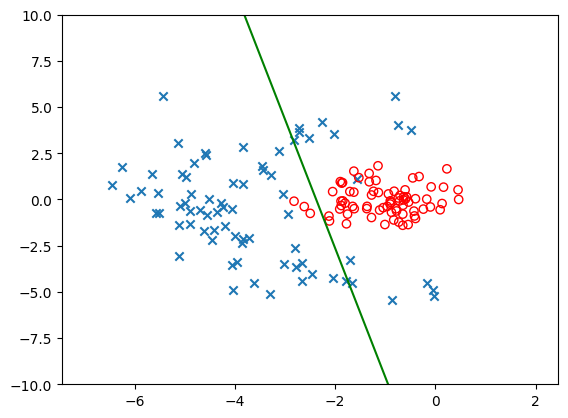

In [138]:
path = 'data/ds-2.txt'
data = DataSet(path)
first_feature = 1
second_feature = 2
class_1_dataset = data.training[data.training[:,0] == 1]
class_2_dataset = data.training[data.training[:,0] == 2]
class_1_feature_1 = class_1_dataset[:,first_feature]
class_2_feature_1 = class_2_dataset[:,first_feature]
class_1_feature_2 = class_1_dataset[:,second_feature]
class_2_feature_2 = class_2_dataset[:,second_feature]

a = [-0.99040224 -0.41639203 -0.05977857]

plt.scatter(class_1_feature_1, class_1_feature_2, marker='x', edgecolors='b')
plt.scatter(class_2_feature_1, class_2_feature_2, facecolors='none', edgecolors='r')

def f(x):
    a_0 = -0.99040224
    a_1 = -0.41639203
    a_2 = -0.05977857
    return -(a_1/a_2)*x -(a_0/a_2)

x = np.linspace(-7, 2, 100)
y = f(x)
plt.plot(x, y, 'g')
plt.ylim(-10, 10)
